## Learning rate schedulers

<img src="image.png" alt="Cool art" width="250">

In this blog, we will learn about Pytorch optimizers and learning rate schedulers. From all the learning rate schedulers, we will learn about `CosineAnnealingLR` and `OneCycleLR` by writing them from scratch.

We can use a learning rate scheduler to vary the learning rate while training. Why do we want to change the learning rate? Let's take a look at an example.

So, let's assume we are stranded in the desert while traveling because our vehicle broke down. We are thirsty, so we want to find some water. We get out of the car to find a well. Thankfully, we have a device that beeps when close to a body of water. The more water, the louder the beep. So, we walk in different directions to figure out where to go. After figuring out the direction, we can run for fast travel. When we are close to water, we want to slow down to find exactly where to dig to find the water. We don't want to go past the water and come back.

By changing learning rate, we can change the speed of the training of the model. With the scheduler, we want to start with a small learning rate. In the beginning, our model is trying to figure out which direction to travel to reduce the loss. After it knows where to step, we can increase the learning rate to take bigger steps. In the end of the training, it's so close to the ideal point, and we don't want to go past. Therefore, we lower the learning rate to fine tune.

So, let's see this in action.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'
!pip -q install torcheval
!pip -q install datasets

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00


In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.xtras import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
dls = get_dls()
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

## Pytorch optimizers

Before we look into schedulers, we need to look at Pytorch optimizers. We know how optimizers work in general from last blog, but Pytorch optimizers are a little bit different. To initialize a Pytorch optimizer, we need parameters and a learning rate.

In [5]:
model = get_model()
opt = optim.SGD(model.parameters(), lr=0.1)
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

We can also grab an optimizer from the learner. With `SingleBatchCB`, we can stop the training after one batch. This way, every initialization step is run, and we know there is no error when the batch ran.

In [6]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit()

In [7]:
opt = learn.opt
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Optimizers store states for updating the weights. To access the states, we have to use parameters as keys because they are dictionaries.

In [8]:
params = next(iter(learn.model.parameters()))
opt.state[params]

{'momentum_buffer': None}

In [9]:
len(params)

8

Parameters are also divided into param_groups. This will be useful later when we want to apply different learning rates for each parameter group.

In [10]:
len(opt.param_groups)

1

In [11]:
list(opt.param_groups[0])

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [12]:
type(opt.param_groups[0])

dict

We can also modify learning rates.

In [13]:
opt.param_groups[0]['lr'] = 1
opt.param_groups[0]['lr']

1

## Scheduler

### CosignAnnealingLR

It's time to look at schedulers. Let's look at `CosineAnnealingLR` and see how the learning rate changes by plotting it. To create a scheduler, we have to pass in an optimizer and the number of total steps. The optimizer stores states such as learning rate, and total steps are used to determine how to change the learning rate.

In [14]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)
sched

We can use `step` and `get_last_lr` to update and get the learning rate.

In [15]:
sched.get_last_lr()

[1]

Let's plot the function to see how the learning rate changes.

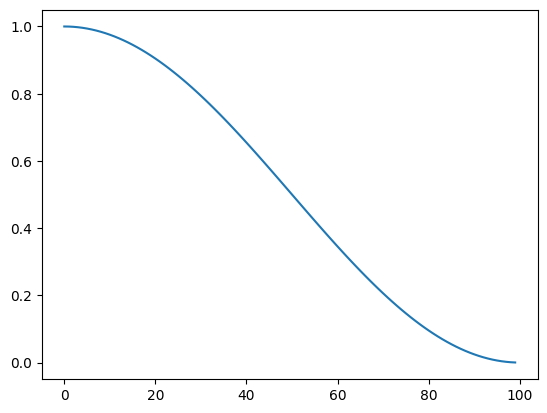

In [16]:
lrs = []
for i in range(100):
    lrs.append(sched.get_last_lr())
    opt.step()
    sched.step()
plt.plot(lrs);

We can create a plotting function to explore more. If we step more than t_max, we can see the cosine curve coming up. We can also use `eta_min` to set the minimum of the learning rate.

In [20]:
def get_opt(lr=0.1): return optim.SGD(get_model().parameters(), lr=lr)

In [21]:
def plot_lrs(scheduler, opt, n_steps=None, **kwargs):
    sched = scheduler(opt, **kwargs)
    sched_lrs = []
    for i in range(n_steps):
        sched_lrs.append(sched.get_last_lr())
        opt.step()
        sched.step()

    plt.plot(sched_lrs);

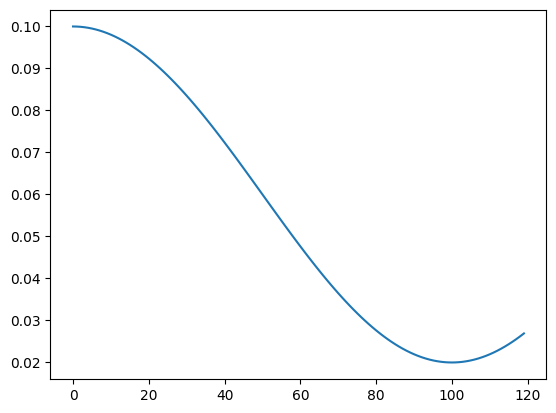

In [22]:
plot_lrs(lr_scheduler.CosineAnnealingLR, get_opt(), T_max=100, n_steps=120, eta_min=.02)

It's time to write it from scratch.

In [51]:
class Scheduler:
    def __init__(self, opt, T_max):
        self.opt = opt
        self.T_max = T_max
        self.cur_T = 1
        self.max_lr = opt.param_groups[0]['lr']

In [24]:
class CosineAnnealing(Scheduler):
    def __init__(self, opt, T_max):
        super().__init__(opt, T_max)

    def step(self):
        new_lr = .5*(self.max_lr)*(1+torch.cos(tensor(self.cur_T/self.T_max*torch.pi)))
        self.opt.param_groups[0]['lr'] = new_lr
        self.cur_T += 1

    def get_last_lr(self): return self.opt.param_groups[0]['lr']

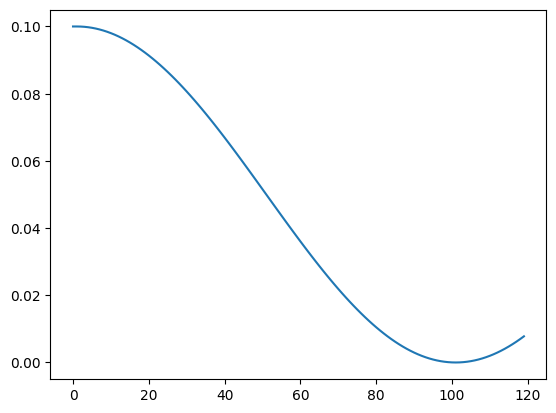

In [26]:
plot_lrs(CosineAnnealing, get_opt(), T_max=100, n_steps=120)

Now, let's see how it performs in the model. We will update the learning rate each batch. We will also record the learning rates.

In [27]:
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [28]:
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [29]:
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]

    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [31]:
def _lr(cb): return cb.pg['lr']

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [32]:
T_max = len(dls.train) * 3
sched = partial(CosineAnnealing, T_max=T_max)

act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=False), astats]

In [33]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

accuracy,loss,epoch,train,time
0.796,0.552,0,True,00:23
0.853,0.404,0,False,00:02
0.876,0.341,1,True,00:21
0.872,0.354,1,False,00:02
0.891,0.299,2,True,00:25
0.877,0.338,2,False,00:02


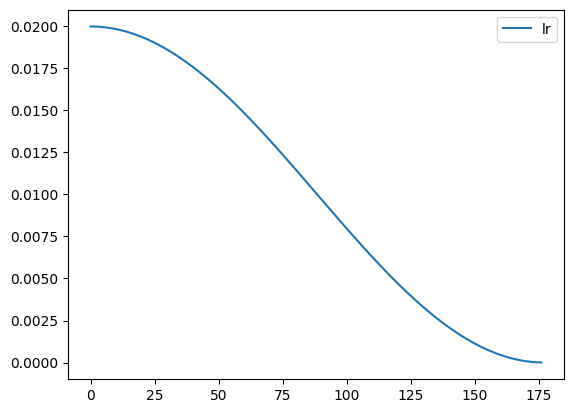

In [34]:
rec.plot()

### OneCycleLR

Now, let's go over `OneCycleLR`. This technique came from [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186) by Leslie Smith. He experimented a lot with hyperparameters like learning rate, momentum, batch size, and weight decay. In the paper, he went over *triangular* learning rate policy. Let's see what it looks like from Pytorch's version.

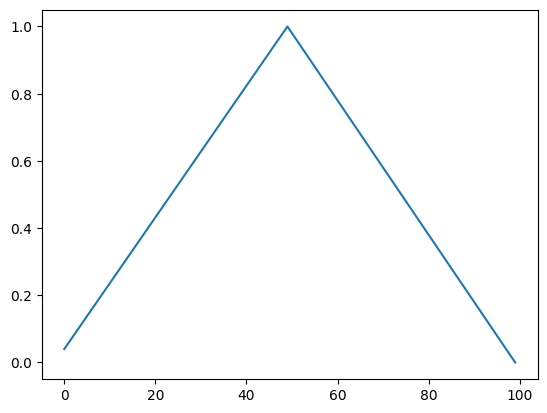

In [35]:
plot_lrs(lr_scheduler.OneCycleLR, get_opt(), n_steps=100, max_lr=1, total_steps=100, anneal_strategy='linear', three_phase=False, pct_start=.5)

Why does our model starts from the lowest to maximum and back down to the lowest? As menteioned before, it starts with the lowest to warm up. As it trains, it finds where to step, so we can take bigger steps. Then, we slow down to fine tune.


It's very simple to implement. We can easily write the program.

In [56]:
class OneCycle(Scheduler):
    def __init__(self, opt, T_max, min_lr=0.):
        super().__init__(opt, T_max)
        self.min_lr = min_lr
        self.opt.param_groups[0]['lr'] = self.min_lr

    def step(self):
        cycle = math.floor(1 + self.cur_T/(2* self.T_max/2))
        x = abs(self.cur_T / (self.T_max/2) - 2*cycle + 1)
        new_lr = self.min_lr + (self.max_lr - self.min_lr) * max(0, 1-x)
        self.opt.param_groups[0]['lr'] = new_lr
        self.cur_T += 1

    def get_last_lr(self): return self.opt.param_groups[0]['lr']

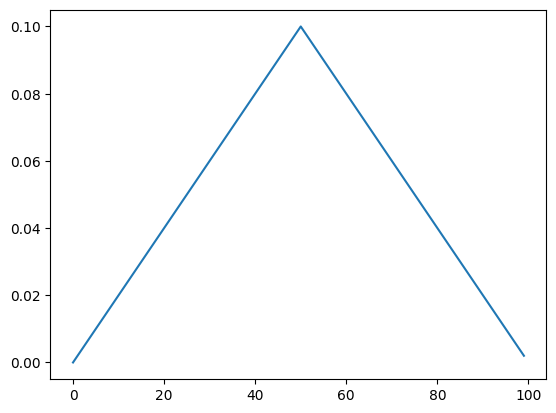

In [57]:
plot_lrs(OneCycle, get_opt(), n_steps=100, T_max=100)

That looks good. Let's try it out.

In [58]:
T_max = len(dls.train) * 3
sched = partial(OneCycle, T_max=T_max)
rec = RecorderCB(lr=_lr)

set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

accuracy,loss,epoch,train,time
0.711,0.814,0,True,00:25
0.834,0.462,0,False,00:02
0.862,0.375,1,True,00:22
0.871,0.359,1,False,00:01
0.892,0.294,2,True,00:23
0.883,0.322,2,False,00:02


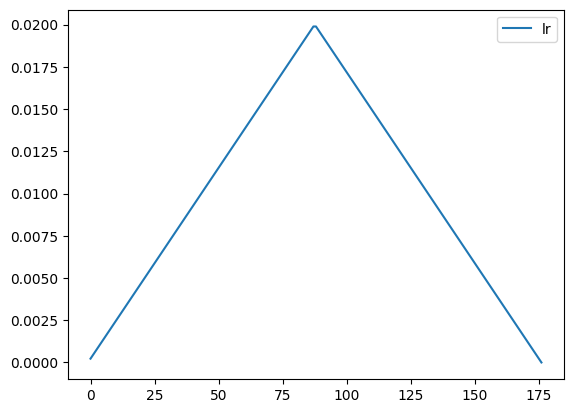

In [59]:
rec.plot()

With `OneCycle`, we can increase the learning rate a bit more. Try it out and see how much you can increase.



By default, Pytorch's `OneCycleLR` uses cosine annealing to modify both learning rate and momentum for the batch norm. In [A disciplined approach to neural network hyper-parameters: Part 1](https://arxiv.org/abs/1803.09820), Leslie Smith talks about how there is a balance in regularization using learning rate, batch size, momentum, and weight decay. To summarize,
- High batch size: high regularization
- High weight decay: high regularization
- High learning rate: high regularization
- High momentum: high regularization

Learning rate and momentum are more closely related. When using high regularization, learning rate has to be reduced, and vice versa. That's what the Pytroch's `OneCycleLR` takes advantage of.


In [66]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

In [67]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.772,0.646,0,True,00:23
0.844,0.461,0,False,00:01
0.857,0.395,1,True,00:21
0.866,0.369,1,False,00:02
0.885,0.311,2,True,00:23
0.879,0.334,2,False,00:01
0.901,0.266,3,True,00:25
0.891,0.296,3,False,00:02
0.918,0.224,4,True,00:22
0.897,0.283,4,False,00:01


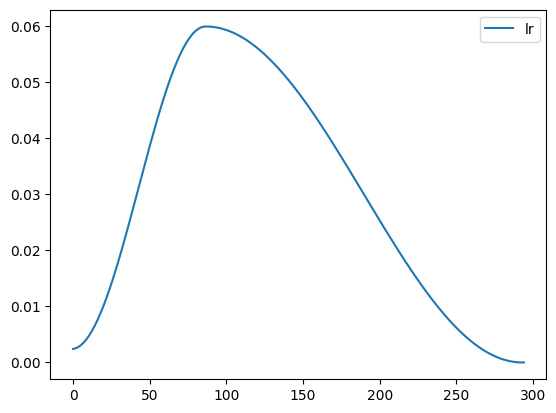

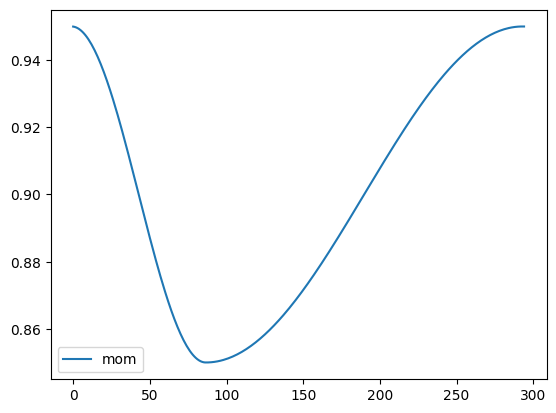

In [68]:
rec.plot()

## Conclusion

In this blog, we learned about Pytorch optimizers and schedulers. We were already familiar with optimizers, but we learned how Pytorch optimizers store states. Then, we went over `CosignAnnealingLR` and `OneCycleLR` schedulers and wrote them from scratch. We also went over Leslie Smith's papers regarding balancing regularization and scheduling learning rates.